# Evaluation of NicheCompass Results

## Setup

### Control Flow

### Import modules

In [2]:
import itertools
from functools import reduce
from datetime import datetime
from pathlib import Path

import torch
from sklearn.preprocessing import minmax_scale
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from statsmodels.graphics import mosaicplot
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
import numpy as np
np.random.seed(1776)

import nichecompass
from nichecompass.models import NicheCompass


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Setup paths

In [3]:
notebook_name = "4-NicheCompass_Downstream.ipynb" 
notebook_path = Path.cwd() / notebook_name
load_adata_timestamp = "2024-12-04_10-11-05"
load_model_timestamp = "2024-11-26_08-36-17"
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


data_folder_path = Path.cwd().parent / ".data"
nichecompass_data_path = data_folder_path / "nichecompass" 

### Load Data

In [4]:
adata = sc.read_h5ad(data_folder_path / "processed" / "preprocessing" / f"{load_adata_timestamp}_VisiumHD_mouse_lung_bin2cell_nichecompass.h5ad")
# Load trained model
model = NicheCompass.load(
    dir_path=nichecompass_data_path / "artifacts" / "2-NicheCompass.ipynb" / load_model_timestamp   / "model",
    adata=None,
    adata_file_name="adata.h5ad",
    gp_names_key="nichecompass_gp_names"
)
# Store niches and celltypes back into model.adata
model.adata.obs = model.adata.obs.join(adata.obs["latent_leiden_0.4"])
model.adata.obs = model.adata.obs.join(adata.obs["latent_leiden_0.4_pca"])
model.adata, adata

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1000, n_cat_covariates_embed_input: 0, n_hidden: 256, n_latent: 156, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 156, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1000
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 156, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1000


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/nichecompass/models/utils.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dic

(AnnData object with n_obs × n_vars = 313497 × 1000
     obs: 'bin_count', 'array_row', 'array_col', 'latent_leiden_0.4', 'latent_leiden_0.4_pca'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'nichecompass_active_gp_names', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_sources_categories_label_encoder', 'nichecompass_target_genes_idx', 'nichecompass_targets_categories_label_encoder', 'spatial', 'spatial_neighbors', 'umap'
     obsm: 'X_umap', 'nichecompass_latent', 'spatial', 'spatial_cropped'
     varm: 'nichecompass_gp_sources', 'nichecompass_gp_sources_categories', 'nichecompass_gp_targets', 'nichecompass_gp_targets_categories'
     obsp: 'nichecompass_latent_connectivities', 'nichecompass_latent_distances', 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 313497

In [5]:
data = nichecompass.data.dataprocessors.prepare_data(
    model.adata,
    model.model.cat_covariates_label_encoders_,
    counts_key=None
)["edge_train_data"]
data

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/nichecompass/data/utils.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  torch_sparse_coo_tensor = torch.sparse.FloatTensor(indices, values, shape)


Data(x=[313497, 1000], edge_index=[2, 1658187], edge_attr=[1658187, 2], edge_label=[672345], edge_label_index=[2, 672345])

In [240]:
encoded_data, (edge_index, attention_weights) = (lambda a, b: lambda x: b(a(x)))(
    model.model.encoder.fc_l1,
    lambda x: model.model.encoder.addon_conv_mu(x, data.edge_index, return_attention_weights=True)
)(data.x)
coo_tensor = torch.sparse_coo_tensor(
    indices=edge_index,
    values=attention_weights[:, 0]
)

In [347]:
torch.zeros(model.adata.n_obs, dtype=torch.float32).scatter_reduce(
    0,    
    edge_index[0].to(torch.int64), 
    #attention_weights.mean(axis=1).to(torch.float32), 
    attention_weights[:, 3].to(torch.float32), 
    reduce="sum"
)

tensor([1.3654e-02, 3.0136e-01, 3.9623e+00,  ..., 7.9926e-03, 1.0601e-03,
        4.1986e+00])

In [370]:
# Extracting the node weight (as the sum of the outgoing attention values per node) for all attention heads
node_attention_per_head = torch.stack(
    [torch.zeros(model.adata.n_obs, dtype=torch.float32).scatter_reduce(
    0,    
    edge_index[0].to(torch.int64), 
    attention_weights[:, head].to(torch.float32), 
    reduce="sum") 
    for head in range(model.model.encoder.addon_conv_mu.heads)]
)

In [372]:
n_edges_per_node = torch.zeros(model.adata.n_obs, dtype=torch.float32).scatter_reduce(
    0,    
    edge_index[1].to(torch.int64), 
    torch.ones(edge_index.shape[1]).to(torch.float32),
    reduce="sum"
)
n_edges_per_node

tensor([5., 4., 4.,  ..., 6., 5., 6.])

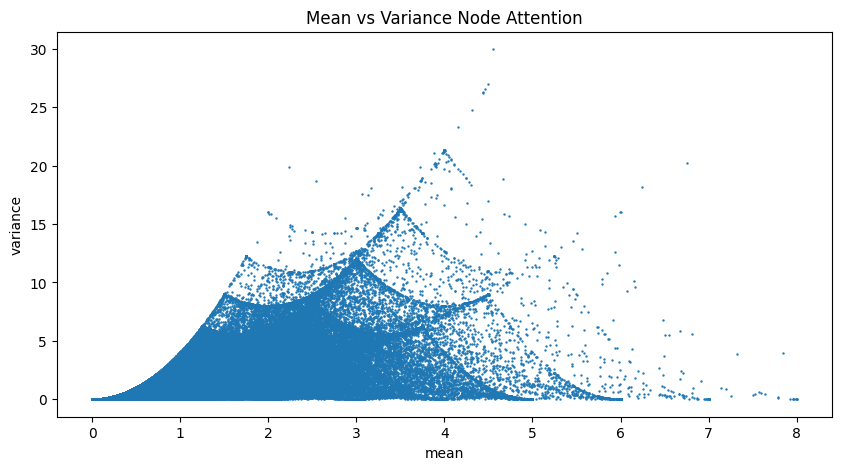

In [440]:
# Plotting relationship of the mean (x-axis) and variance (y-axis) in the attention in each node per head
plt.figure(figsize=(10,5))
plt.scatter(x=node_attention_per_head.mean(axis=0), y=node_attention_per_head.std(axis=0) ** 2, s=0.5)
plt.xlabel("mean")
plt.ylabel("variance")
plt.title("Mean vs Variance Node Attention")
plt.show()

In this step im trying to aggregate the attention weights for each head via partial pooling. When the 4 attention heads "agree" (low variance), the mean of this sample is weighted more strongly, but when variance is high the aggregated value tends towards the mean attention.
$$f(x) = \mu_{\text{sample}} + \left( \mu_{\text{global}} - \mu_{\text{sample}} \right) \times \frac{1}{1 + \exp\left( \frac{\sigma_{\text{sample}}^2 - \mu_{\sigma^2}}{\sigma_{\sigma^2}} \right)}$$
The mean attention over the entire dataset is always 1 so you can replace the global mean like this
$$f(x) = \mu_{\text{sample}} + \left( 1 - \mu_{\text{sample}} \right) \times \frac{1}{1 + \exp\left( \frac{\sigma_{\text{sample}}^2 - \mu_{\sigma^2}}{\sigma_{\sigma^2}} \right)}$$

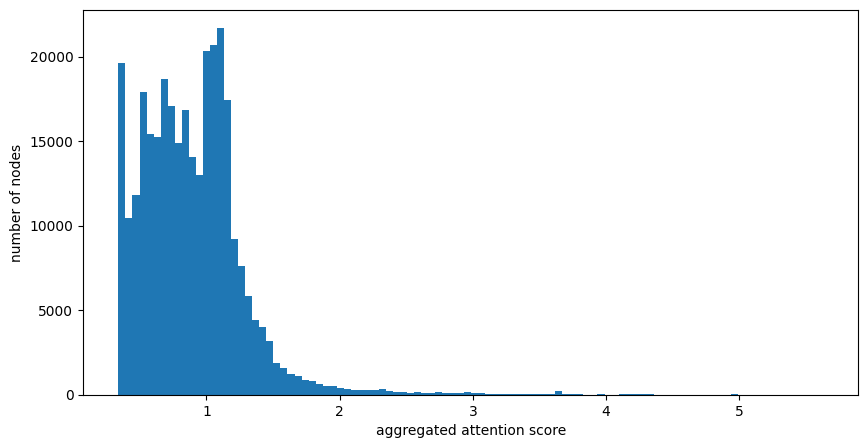

In [447]:
partial_pooling_with_variance_adjustment = (
    lambda arr: 
        arr.mean(axis=0) + 
        (1 - arr.mean(axis=0)) * 
        (1 / (1 + torch.exp(
            -(((arr.std(axis=0) ** 2) - (arr.std(axis=0) ** 2).mean()) / 
              (arr.std(axis=0) ** 2).std()
        )))))
node_attention_aggregated = partial_pooling_with_variance_adjustment(node_attention_per_head)

plt.figure(figsize=(10,5))
plt.hist(node_attention_aggregated, bins=100)
plt.xlabel("aggregated attention score")
plt.ylabel("number of nodes")
plt.show()

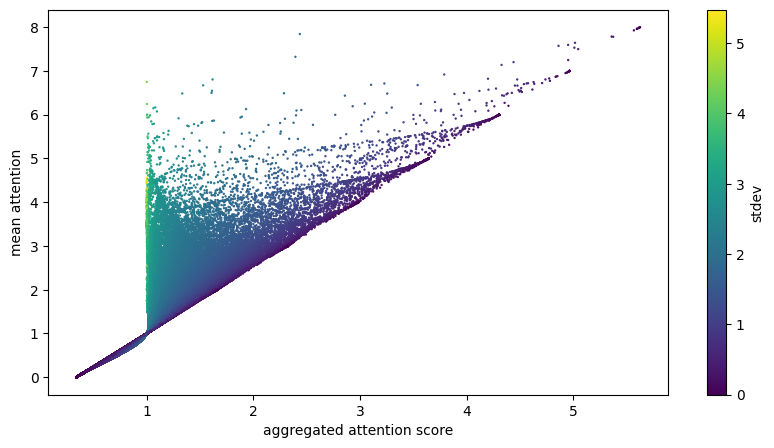

In [474]:
plt.figure(figsize=(10, 5))
scatter = plt.scatter(
    x=node_attention_aggregated, 
    y=node_attention_per_head.mean(axis=0), 
    s=0.5, 
    c=node_attention_per_head.std(axis=0),
    cmap='viridis'
)
plt.colorbar(scatter, label='stdev')
plt.xlabel("aggregated attention score")
plt.ylabel("mean attention")
plt.show()

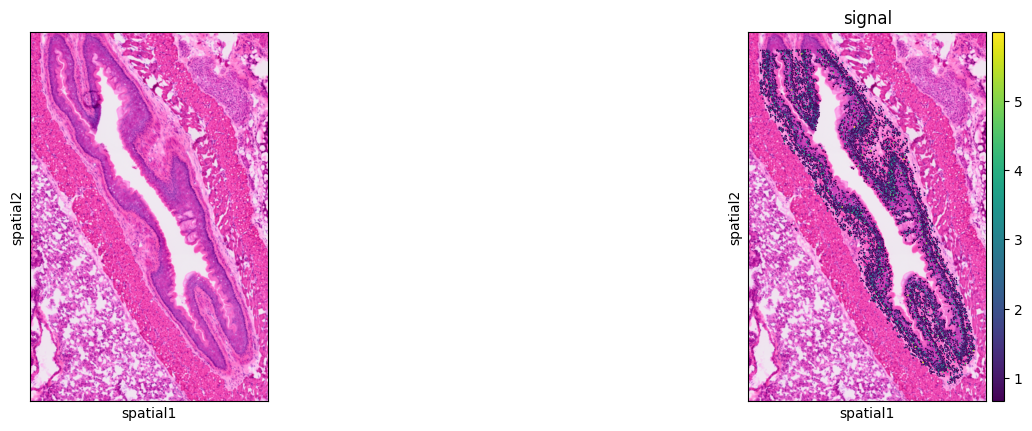

In [298]:
adata_niche = adata[adata.obs["latent_leiden_0.4"] == "10"]
sc.pl.spatial(sc.AnnData(
    X=adata_niche.X,
    obs=adata.obs.assign(signal=test)[adata.obs["latent_leiden_0.4"] == "10"],    
    var=adata_niche.var,
    uns=adata_niche.uns,
    obsm=adata_niche.obsm,
    obsp=adata_niche.obsp
), color=[None, "signal"])

In [ ]:
global_mean = torch.stack([head_weights(head) for head in range(4)]).mean()
sample_means = torch.stack([head_weights(head) for head in range(4)]).mean(axis=0)
sample_variances = torch.stack([head_weights(head) for head in range(4)]).std(axis=0) ** 2
sample_variances_mean = sample_variances.mean()
sample_variances_std= sample_variances.std()

In [98]:
model.model.encoder(data.x, data.edge_index)

(tensor([[-2.6745e+00,  1.7995e+01, -6.6788e+00,  ...,  1.7003e+00,
           8.2714e-01,  8.8221e-02],
         [ 2.1796e-01,  7.6000e+00, -9.2854e-01,  ..., -5.5668e-01,
           6.5362e-01, -4.1099e-01],
         [ 1.8816e-01,  2.7706e+00,  1.5784e+00,  ..., -4.6000e-01,
          -3.6649e-02,  1.6657e-01],
         ...,
         [ 4.4212e-01,  2.3025e-01, -9.4189e-01,  ..., -2.4902e-01,
          -5.7580e-03,  3.7495e-01],
         [ 2.6216e+00, -8.3898e+00, -1.3407e+00,  ...,  3.1601e-01,
           2.4109e-01, -3.4794e-02],
         [ 4.5458e+00, -1.3891e+01,  6.6153e-01,  ...,  1.8108e+00,
           1.5607e+00,  2.1978e+00]]),
 tensor([[-1.9335e+00, -1.6189e+00, -1.1860e+00,  ..., -2.3377e-02,
          -4.2560e-03,  2.3199e-02],
         [-1.5463e+00, -1.4137e+00, -1.4211e+00,  ..., -1.3907e-03,
          -4.9335e-04, -2.3216e-03],
         [-2.0242e+00, -1.5824e+00, -1.5180e+00,  ...,  4.5998e-03,
          -2.0960e-02, -1.8561e-02],
         ...,
         [-1.3720e+00, -1

In [84]:
nichecompass.data.datasets.SpatialAnnTorchDataset(adata)

TypeError: __init__() missing 1 required positional argument: 'cat_covariates_label_encoders'

In [77]:
sorted(list(model.__dict__.keys()))

['active_gp_names_key_',
 'active_gp_thresh_ratio_',
 'active_gp_type_',
 'adata',
 'adata_atac',
 'adj_key_',
 'agg_weights_key_',
 'ca_sources_mask_',
 'ca_sources_mask_key_',
 'ca_targets_mask_',
 'ca_targets_mask_key_',
 'cat_covariates_cats_',
 'cat_covariates_embeds_injection_',
 'cat_covariates_embeds_keys_',
 'cat_covariates_embeds_nums_',
 'cat_covariates_keys_',
 'cat_covariates_no_edges_',
 'conv_layer_encoder_',
 'counts_key_',
 'dropout_rate_encoder_',
 'dropout_rate_graph_decoder_',
 'encoder_n_attention_heads_',
 'encoder_use_bn_',
 'features_idx_dict_',
 'features_scale_factors_',
 'freeze_',
 'gene_expr_recon_dist_',
 'gene_peaks_mask_key_',
 'genes_idx_key_',
 'gp_names_key_',
 'gp_sources_categories_mask_key_',
 'gp_sources_mask_',
 'gp_sources_mask_key_',
 'gp_targets_categories_mask_key_',
 'gp_targets_mask_',
 'gp_targets_mask_key_',
 'include_cat_covariates_contrastive_loss_',
 'include_chrom_access_recon_loss_',
 'include_edge_kl_loss_',
 'include_edge_recon_los

In [73]:
model.model

VGPGAE(
  (rna_node_label_aggregator): OneHopGCNNormNodeLabelAggregator()
  (encoder): Encoder(
    (fc_l1): Linear(in_features=1000, out_features=256, bias=True)
    (conv_mu): GATv2Conv(256, 156, heads=4)
    (conv_logstd): GATv2Conv(256, 156, heads=4)
    (addon_conv_mu): GATv2Conv(256, 100, heads=4)
    (addon_conv_logstd): GATv2Conv(256, 100, heads=4)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (graph_decoder): CosineSimGraphDecoder(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (target_rna_decoder): MaskedOmicsFeatureDecoder(
    (nb_means_normalized_decoder): AddOnMaskedLayer(
      (masked_l): MaskedLinear(in_features=156, out_features=1000, bias=False)
      (addon_l): MaskedLinear(in_features=100, out_features=1000, bias=False)
      (activation): Softmax(dim=-1)
    )
  )
  (source_rna_decoder): MaskedOmicsFeatureDecoder(
    (nb_means_normalized_decoder): AddOnMaskedLayer(
      (masked_l): MaskedLinear(in_features=156, out_features=1000, bias=False)
      (addo

In [46]:
model.model.encoder.addon_conv_mu._parameters["att"]

Parameter containing:
tensor([[[-4.1452e-03, -7.5192e-02,  4.7935e-03, -5.2491e-02, -1.5054e-02,
           2.0601e-02, -9.7456e-03, -1.7944e-02, -3.5217e-02, -3.9796e-02,
           4.4304e-03, -1.4516e-02,  2.3645e-02,  7.2699e-04,  4.0838e-02,
           6.0574e-02, -1.6013e-03, -6.0669e-03,  1.3000e-01, -2.4702e-03,
          -7.2217e-05, -1.3111e-02, -1.6329e-01,  2.5409e-02,  1.7078e-02,
           8.4580e-02, -4.3052e-02,  4.0650e-03,  1.4068e-02,  3.4199e-03,
          -2.3400e-01, -3.0182e-02, -4.6837e-02, -3.6554e-02,  1.6233e-01,
           4.4136e-02,  7.1707e-02,  6.8810e-03,  9.8644e-03,  4.3201e-04,
           1.6106e-01,  4.1341e-03,  1.4684e-02, -1.4246e-03, -5.0297e-02,
           2.3712e-02, -4.9505e-02, -3.7700e-02, -2.1009e-03,  1.5577e-02,
          -9.9530e-03,  1.4459e-02, -2.2270e-03,  8.5155e-02, -2.8624e-02,
          -1.0613e-03, -2.1996e-03, -1.5542e-03, -5.0672e-02,  2.6646e-02,
          -1.1600e-04, -6.9661e-02,  1.5681e-02,  3.2732e-02, -5.7707e-02,
   

In [24]:
for key in sorted(list(key for key in model.model.encoder.addon_conv_mu.__dict__.keys())):
    print(key)

_aggregate_forward_hooks
_aggregate_forward_pre_hooks
_apply_sigmoid
_backward_hooks
_backward_pre_hooks
_buffers
_decomposed_layers
_edge_mask
_edge_update_forward_hooks
_edge_update_forward_pre_hooks
_edge_user_args
_explain
_forward_hooks
_forward_hooks_always_called
_forward_hooks_with_kwargs
_forward_pre_hooks
_forward_pre_hooks_with_kwargs
_fused_user_args
_is_full_backward_hook
_load_state_dict_post_hooks
_load_state_dict_pre_hooks
_loop_mask
_message_and_aggregate_forward_hooks
_message_and_aggregate_forward_pre_hooks
_message_forward_hooks
_message_forward_pre_hooks
_modules
_non_persistent_buffers_set
_parameters
_propagate_forward_hooks
_propagate_forward_pre_hooks
_state_dict_hooks
_state_dict_pre_hooks
_user_args
add_self_loops
aggr
concat
dropout
edge_dim
fill_value
flow
fuse
heads
in_channels
inspector
lin_edge
negative_slope
node_dim
out_channels
residual
share_weights
training


In [17]:
model.model.encoder.addon_conv_mu

GATv2Conv(256, 100, heads=4)

In [8]:
model.__dict__

{'adata': AnnData object with n_obs × n_vars = 313497 × 1000
     obs: 'bin_count', 'array_row', 'array_col', 'latent_leiden_0.4', 'latent_leiden_0.4_pca'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'nichecompass_active_gp_names', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_sources_categories_label_encoder', 'nichecompass_target_genes_idx', 'nichecompass_targets_categories_label_encoder', 'spatial', 'spatial_neighbors', 'umap'
     obsm: 'X_umap', 'nichecompass_latent', 'spatial', 'spatial_cropped'
     varm: 'nichecompass_gp_sources', 'nichecompass_gp_sources_categories', 'nichecompass_gp_targets', 'nichecompass_gp_targets_categories'
     obsp: 'nichecompass_latent_connectivities', 'nichecompass_latent_distances', 'spatial_connectivities', 'spatial_distances',
 'adata_atac': None,
 'counts_key_'